# Introduction

This notebook contains functions that can be used to perform various operations
on a given array of rays of light. These functions can be used to calculate
the refraction of rays of light through planar and spherical surfaces, as well
as calculating the intersection of the rays with an opaque detector surface.
This module also contains functions that trace the rays of light through a
specified combination of surfaces, and produces a plot of the final paths of the
rays. Additionally, the quality of the image formed on a final detector surface 
can be evaluated and optimised by varying the values of the radii of convergence 
of specified spherical lenses.

### Imports

In [8]:
# Imports the necessary functions for mathematics, operating on arrays, for 
# plotting the paths of any specified rays and for labelling the plots produced.
import numpy
import matplotlib.patches as mpatches
import matplotlib.pyplot as pyplot

# Imports the function required for optimizing in optimize_surf_rad_2d.  NOT CURRENTLY IMPLEMENTED
# from scipy.optimize import minimize

# Modeling

## refraction_2d

refraction_2d(incident_rays, planar_surface)
    
Takes two arguments, incident_rays and planar_surface, and returns 
refracted_rays. Calculates the paths of incident rays as they refract 
through a planar surface. incident_rays is a 2-dimensional numpy array where 
the first index specifies an individual light ray, and the second index 
specifies the origin of the light ray in terms of the x coordinate, y 
coordinate and clockwise angle from the vertical of the ray in that order.
planar_surface is a 1-dimensional numpy array of floats, specifying the x
coordinate of one end of the surface, the corresponding y coordinate, the x
coordinate of the other end of the surface, the corresponding y coordinate,
the refractive index of the material on the incident side of the surface, 
and the refractive index of the material on the opposite side of the 
surface. refracted_rays is a 2-dimensional array of similar dimensions to
incident_rays, this time with the first index again specifying an individual
light ray, and the second index specifying the location and direction of the
refracted ray with the x coordinate, the y coordinate and the clockwise 
angle from the vertical of the refracted ray. An exception is raised if the
incident angle of a ray on the surface exceeds the critical angle for the
specified values of refracted indices, since refraction is impossible in 
such a case.

In [11]:
def refraction_2d(incident_rays, planar_surface):

    # set up array to hold results
    refracted_rays = numpy.zeros(incident_rays.shape, dtype=float)
    # NOTE: this is ONE option to avoid a transpose when constructing the 
    # returned array of results
    
    # calculate critical angle
    if planar_surface[5] >= planar_surface[4]:
        # total internal reflection is not possible - save computational time by
        # not calculating the critical angle
        tir_possible = False
    else:
        tir_possible = True
        critical_angle = numpy.arcsin(planar_surface[5]/planar_surface[4])
    
    # calculate angles to surface normal of incident rays
    planar_angle = numpy.arctan((planar_surface[2]-planar_surface[0])/(planar_surface[3]-planar_surface[1]))
    # transform ray angles to be with respect to normal to surface
    incident_angles =  incident_rays[:,2] - (numpy.pi/2.0) - planar_angle 
    
    # handle incident rays exceeding the critical angle
    if tir_possible and(abs(incident_angles) > critical_angle).any():
        raise Exception("One or more of the incident angles exceeds the \
        critical angle, these rays are reflected instead of refracted.")
    
    # calculate gradients and intercepts of incoming rays and surface
    ray_gradients = numpy.tan((numpy.pi/2.0) - incident_rays[:,2])
    ray_intercepts = incident_rays[:,1] - (ray_gradients * incident_rays[:, 0])
    surface_gradient = (planar_surface[3]-planar_surface[1])/(planar_surface[2]-planar_surface[0])
    surface_intercept = planar_surface[1] - (surface_gradient * planar_surface[0])

    # calculate points of intersection of rays with surface...
    # horizontal
    refracted_rays[:,0] = (surface_intercept - ray_intercepts) / (ray_gradients - surface_gradient)
    # vertical
    refracted_rays[:,1] = (ray_gradients * refracted_rays[:,0]) + ray_intercepts
    
    # calculate directions of refracted rays
    refracted_angles = numpy.arcsin(planar_surface[4]*numpy.sin(incident_angles)/planar_surface[5]) 
    # Snell's law
    refracted_rays[:,2] = refracted_angles + (numpy.pi/2.0) + planar_angle 
    # transform output ray angles to be clockwise from vertical
    
    return refracted_rays

## refraction_2d_sph


refraction_2d_sph(incident_rays, spherical_surface)
    
Takes two arguments, incident_rays and spherical surface, and returns 
refracted_rays. Calculates the paths of incident rays as they refracted 
through a spherical surface. incident_rays is a 2-dimensional numpy array of
floats, with the first index specifying the individual light ray, and the 
second index specifying the following values in this order: the horizontal 
coordinate of the point of origin of the ray in metres, the vertical 
coordinate of the point of origin of the ray in metres, and the clockwise 
angle in radians with respect to the positive vertical direction of the 
incident ray. spherical_surface is a 1-dimensional numpy array of floats, 
with the following specified values in this order: the horizontal coordinate
of one end of the arc in metres, its corresponding vertical coordiante, the
horizontal coordinate of the other end of the arc, its corresponding 
vertical coordinate, the refractive index of the medium on the incident side
of the surface, the refractive index on the outgoing side of the surface, 
and lastly the radius of curvature of the surface in metres. A positive 
radius of curvature indicates that a ray travelling in the positive x 
direction will intersect a convex surface, whereas a negative radius of 
curvature will indicate that such a ray will intersect a concave surface. 
refracted_rays is a 2-dimensional numpy array of floats, with the first 
index specifying the individual light ray, and the second index specifying 
the following values in this order: the horizontal coordinate of the point 
of origin of the ray in metres, the vertical coordinate of the point of 
origin of the ray in metres, and the clockwise angle in radians with respect
to the positive vertical direction of the refracted ray. An exception is 
raised if the incident angle of a ray on the surface exceeds the critical 
angle for the specified values of refracted indices, since refraction is 
impossible in such a case. 

In [13]:
def refraction_2d_sph(incident_rays, spherical_surface):
    
    # Set up an array to hold results.
    refracted_rays = numpy.zeros(incident_rays.shape, dtype=float)
    
    # Calculate the gradients and intercepts of the incident light rays as if 
    # they were lines in a cartesian plane.
    ray_gradients = numpy.tan(numpy.pi/2.0  - incident_rays[:,2])
    ray_intercepts = incident_rays[:,1] - (ray_gradients * incident_rays[:,0])

    # By modelling the spherical lens as the arc of a circle, the x coordinate
    # of the centre of this circle can be found. Depending on whether the lens 
    # is converging or diverging, the centre of the lens will be at a different 
    # location and an if/else statement is used to check this. Intermediate 
    # quantities are defined to make the equations less complicated.
    lens_height = spherical_surface[1] - ((spherical_surface[1]+spherical_surface[3])/2.0)
    adjacent_side_squared = (spherical_surface[6]**2.0) - lens_height**2.0
    
    if spherical_surface[6] > 0:
        centre_x = spherical_surface[0] + numpy.sqrt(adjacent_side_squared)
    else:
        centre_x = spherical_surface[0] - numpy.sqrt(adjacent_side_squared)

    # The intersection points of the rays with the lens can be found by equating
    # the equations of the rays and that of the circle and solving them 
    # simultaneously. This results in a quadratic equation with coefficients
    # a, b, and c as below. The two solutions represent the two intersections
    # of the rays as they pass in and out of the circle. Repeated solutions are
    # not considered because physically these rays do not pass through the lens.
    a = (1.0 + ray_gradients**2.0)
    b = (-2.0*centre_x + 2.0*ray_gradients*ray_intercepts)
    c = (centre_x**2.0 + ray_intercepts**2.0 - spherical_surface[6]**2.0)

    # In the case of a converging lens (radius of convergance is positive) the
    # x intersection is given by the negative root of the quadratic. In the case
    # of a diverging lens ( radius of convergence is negative) the x 
    # intersection is given by the positive root of the quadratic.
    if spherical_surface[6] > 0.0:
        x_intersect = ((-1.0*b - numpy.sqrt(b**2.0 - 4.0*a*c))/(2.0*a))
    elif spherical_surface[6] < 0.0:
        x_intersect = ((-1.0*b + numpy.sqrt(b**2.0 - 4.0*a*c))/(2.0*a))
    
    # Substitute into the equation of the rays to find the corresponding 
    # y value of the intersection point.
    y_intersect = (ray_gradients*x_intersect + ray_intercepts)
    
    # This value will be needed to convert angles from the vertical to angles
    # from the normal of the spherical surface at the intersection point.
    radius_angle = numpy.arctan(y_intersect/(centre_x - x_intersect))
    
    # Convert angles from the vertical to angles from the normal
    incident_angles = numpy.pi/2.0 - incident_rays[:,2] + radius_angle
    
    if spherical_surface[5] >= spherical_surface[4]:
        # Total internal reflection not possible, saves computational time by
        # not calculating the critical angle.
        tir_possible = False
    else:
        tir_possible = True
        critical_angle = numpy.arcsin(spherical_surface[5]/spherical_surface[4])
    
    if tir_possible and(abs(incident_angles) > critical_angle).any():
        raise Exception("One or more of the incident angles exceeds the \
        critical angle, these rays are reflected instead of refracted.")
    
    # Uses Snell's Law to calculate refracted angles from the normal of surface.
    n1 = spherical_surface[4]
    n2 = spherical_surface[5]
    refracted_angle = numpy.arcsin((n1*numpy.sin(incident_angles)) / n2)

    # Contructs and returns refracted_rays.
    refracted_rays[:,0] = x_intersect
    refracted_rays[:,1] = y_intersect
    
    # Converts refracted angles from the normal of the surface to refracted 
    # angles clockwise from the vertical.
    refracted_rays[:,2] = (numpy.pi/2.0) - refracted_angle + radius_angle
    
    return refracted_rays

## refraction_2d_det

refraction_2d_det(incident_rays, x_det)
    
Takes two arguments, incident_rays and x_det, and returns refracted_rays.
Calculates the paths of incident rays as they strike a detector surface.
incident_rays is a 2-dimensional numpy array of floats, with the first index
specifying the individual light ray, and the second index specifying the 
following values in this order: the horizontal coordinate of the point of 
origin of the ray in metres, the vertical coordinate of the point of origin 
of the ray in metres, and the clockwise angle in radians with respect to the
positive vertical direction of the incident ray. x_det is a single float 
value specifying the x coordinate of a vertical, opaque detector surface. 
refracted_rays is a 2-dimensional numpy array of floats, with the first 
index specifying the individual light ray, and the second index specifying 
the following values in this order: the horizontal coordinate of the point 
of origin of the ray in metres, the vertical coordinate of the point of 
origin of the ray in metres, and the clockwise angle in radians with respect
to the positive vertical direction of the refracted ray. In this case, the 
clockwise angles of the rays will be returned as zero, since the detector
surface will be used as a final surface to project the image of the rays on.
Therefore since no further refraction will occur, the values of the returned
angles are unimportant.

In [14]:
def refraction_2d_det(incident_rays, x_det):
    
    refracted_rays = numpy.zeros(incident_rays.shape, dtype=float)

    # Calculates the gradients and intercepts of the incident light rays as if 
    # they were lines in a cartesian plane.    
    m = numpy.tan(numpy.pi/2.0  - incident_rays[:,2])
    c = incident_rays[:,1] - (m * incident_rays[:,0])
    
    # Calculates y intersection of rays with the detector.
    y_intersection = m*x_det + c
    
    # Sets the values of the x intersections to x_det, since the intersection
    # points are guaranteed to have this value given that they hit the detector.
    x_intersection = incident_rays[:,0]
    x_intersection = x_det
    
    # Sets the values of the refracted angles to zero - these values are 
    # irrelevant now.
    refracted_angles = incident_rays[:,2]
    refracted_angles = 0
    
    # Constructs and returns refracted_rays.
    refracted_rays[:,0] = x_intersection
    refracted_rays[:,1] = y_intersection
    refracted_rays[:,2] = refracted_angles

    return refracted_rays

## trace_2d

trace_2d(incident_rays, surface_list)
    
Takes two arguments, incident_rays and surface_list, and returns 
refracted_ray_paths. Calculated the paths of incident rays as they refract
through a given combination of defined planar, spherical and detector 
surfaces. incident_rays is a 2-dimensional numpy array of floats,
with the first index specifying the individual light ray, and the second 
index specifying the following values in this order: the horizontal 
coordinate of the point of origin of the ray in metres, the vertical 
coordinate of the point of origin of the ray in metres, and the clockwise 
angle in radians with respect to the positive vertical direction of the 
incident ray. surface_list is a list of lists containing the details of each
surface in turn. The first index specifies a list corresponding to each 
surface. This list contains two elements, the first being a string, either
"PLA", "SPH" or "DET", indicating whether the surface being specified is a
planar surface, spherical surface or detector surface respectively. The 
second element of the list in the case of "PLA" is a 1-dimensional numpy 
array specifying details of the planar surface in similar format to before.
In the case of "SPH", the second element is a 1-dimensional numpy array 
specifying details of the spherical surface in a similar format to before. 
Finally in the case of "DET" the second element is a single float value 
specifying the value of x_det for the surface. refracted_ray_paths is a 
3-dimensional numpy array containing the refracted_rays output for each 
surface the rays pass through in turn. Therefore the first index specifies
the surface, the second index specifies the refracted_rays value for each 
ray of light, and the third index specifies either the x coordinate, y
coordinate or refracted angle clockwise from the vertical of the ray. The
list of surfaces will only end with a detector surface, so the output of the
refracted ray angles for this final surface are not calculated, and all take
the value of zero.

In [15]:
def trace_2d(incident_rays, surface_list):
    
    # Create arrays of zeros to hold results
    refracted_ray_paths = numpy.zeros([len(surface_list), incident_rays.shape[0], incident_rays.shape[1]])
    refracted_rays = numpy.zeros(incident_rays.shape, dtype=float)
    
    # Initialize i for iterating through surfaces
    i = 0
    
    # Iterate through surface list, checking the type of the surface and then 
    # passing values to the appropriate function.
    while i < len(surface_list):
        if surface_list[i][0] == "PLA":
            refracted_rays = refraction_2d(incident_rays, surface_list[i][1])
        elif surface_list[i][0] == "SPH":
            refracted_rays = refraction_2d_sph(incident_rays, surface_list[i][1])
        elif surface_list[i][0] == "DET":
            refracted_rays = refraction_2d_det(incident_rays, surface_list[i][1])
            
        # Outputs the refracted ray values to the appropriate index of
        # refracted_ray_paths.
        refracted_ray_paths[i] = refracted_rays
        
        # Increment i and set the new incident_rays values to the refracted_rays
        # of the previous surface, so that the rays are traced through every
        # surface in turn 
        i += 1
        incident_rays = refracted_rays
        
    return refracted_ray_paths

## plot_trace_2d

plot_trace_2d(incident_rays, refracted_ray_paths, surface_list)
    
Takes three arguments, incident_rays, refracted_ray_paths and surface_list,
and does not return any values. Produces a plot showing the path each ray
takes through the combination of surfaces specified by surface list. 
incident_rays is a 2-dimensional numpy array of floats, with the first index
specifying the individual light ray, and the second index specifying the 
following values in this order: the horizontal coordinate of the point of 
origin of the ray in metres, the vertical coordinate of the point of origin 
of the ray in metres, and the clockwise angle in radians with respect to the
positive vertical direction of the incident ray. refracted_ray_paths is a 
3-dimensional numpy array containing the refracted_rays output for each 
surface the rays pass through in turn. Therefore the first index specifies
the surface, the second index specifies the refracted_rays value for each 
ray of light, and the third index specifies either the x coordinate, y
coordinate or refracted angle clockwise from the vertical of the ray. The
list of surfaces will only end with a detector surface, so the output of the
refracted ray angles for this final surface are not calculated, and all take
the value of zero. surface_list is a list of lists containing the details of
each surface in turn. The first index specifies a list corresponding to each 
surface. This list contains two elements, the first being a string, either
"PLA", "SPH" or "DET", indicating whether the surface being specified is a
planar surface, spherical surface or detector surface respectively. The 
second element of the list in the case of "PLA" is a 1-dimensional numpy 
array specifying details of the planar surface in similar format to before.
In the case of "SPH", the second element is a 1-dimensional numpy array 
specifying details of the spherical surface in a similar format to before. 
Finally in the case of "DET" the second element is a single float value 
specifying the value of x_det for the surface. No values are returned but
a plot is shown when the function has completely plotted all surfaces and 
all rays.

In [16]:
def plot_trace_2d(incident_rays, refracted_ray_paths, surface_list):

    # Prepares a figure to plot the ray trace diagram on.
    pyplot.figure(1)
    
    # Iterates through surfaces plotting them one by one.
    for j in range(0, len(surface_list)):
        if surface_list[j][0] == "PLA":
            
            # Retreives the x and y coordinates of each end of the planar
            # surface in preparation to plot them.
            plane_x_1 = surface_list[j][1][0]
            plane_y_1 = surface_list[j][1][1]
            plane_x_2 = surface_list[j][1][2]
            plane_y_2 = surface_list[j][1][3]
            
            # Plots the planar surface where defined with a blue line.
            pyplot.plot([plane_x_1, plane_x_2], [plane_y_1, plane_y_2], "b")
            
        elif surface_list[j][0] == "DET":
            
            # min_y and max_y are values that will be used to calculate over
            # what range of y values to plot the detector. The detector will be
            # plotted from the minimum to the maximum y values of rays incident
            # on the detector, with a small amount of leeway on each side.
            # min_y is arbitrarily set as a big value and max_y is arbitrarily
            # set as a small value with the expectation that they will be 
            # overwritten later.
            min_y = 1000.0
            max_y = -1000.0
            
            # Checks for the maximum and minimun y values of the rays incident 
            # on the detector surface. 
            for i in range(0, len(refracted_ray_paths[len(refracted_ray_paths)-1])):
                if refracted_ray_paths[len(refracted_ray_paths)-1][i][1] < min_y:
                    min_y = refracted_ray_paths[len(refracted_ray_paths)-1][i][1]
            for i in range(0, len(refracted_ray_paths[len(refracted_ray_paths)-1])):
                if refracted_ray_paths[len(refracted_ray_paths)-1][i][1] > max_y:
                    max_y = refracted_ray_paths[len(refracted_ray_paths)-1][i][1]
            
            # Retreives the value for x_det. Since the only detector will be the
            # final surface, we can guarantee the indices for x_det will be as
            # follows.
            x_det_value = surface_list[len(surface_list) - 1][1]
            
            # Plots the vertical detector surface with a green line.
            pyplot.plot([x_det_value, x_det_value], [min_y - 1.0, max_y + 1.0], "g")
            
        elif surface_list[j][0] == "SPH":
            
            # Check whether the radius of convergence is positive or negative.
            if surface_list[j][1][6] > 0.0:
                
                # Retreives the y values of the top and bottom of the arc for
                # which the surface is defined.
                sphere_y_1 = surface_list[j][1][1] 
                sphere_y_2 = surface_list[j][1][3]
                
                # Generates a large range of y values in the range from the
                # lower y value to the upper y value in increments of 0.01.
                ys = numpy.arange(numpy.amin([sphere_y_1, sphere_y_2]), numpy.amax([sphere_y_1, sphere_y_2]), 0.01)
                
                # Recalculates the centre of the circle, this time using 
                # quantities from surface_list instead of spherical_surface.
                centre_x = (((surface_list[j][1][0]+surface_list[j][1][2])/2.0) + \
                numpy.sqrt((surface_list[j][1][6]**2.0) - (surface_list[j][1][1] - \
                ((surface_list[j][1][1]+surface_list[j][1][3])/2))**2))
                
                # Uses the equation of the circle to find x values corresponding
                # to the generated y values.
                xs = -1.0*numpy.sqrt(surface_list[j][1][6]**2.0 - ys**2) + centre_x
                
                # Plots the x and y values to generate an approximately smooth
                # curved surface with a red line.
                pyplot.plot(xs, ys, "r")
                
            elif surface_list[j][1][6] < 0.0:
                
                # Repeats the same process for a negative radius of convergence.
                # The process is the same except from a minus sign in the 
                # formula for the x coordinate of the centre of the circle, and 
                # the positive root is taken instead of the negative root when
                # calculating the corresponding x values of the generated y
                # values. 
                sphere_y_1 = surface_list[j][1][1] 
                sphere_y_2 = surface_list[j][1][3]
                
                ys = numpy.arange(numpy.amin([sphere_y_1, sphere_y_2]), numpy.amax([sphere_y_1, sphere_y_2]), 0.01)
                
                centre_x = (((surface_list[j][1][0]+surface_list[j][1][2])/2.0) - \
                numpy.sqrt((surface_list[j][1][6]**2.0) - (surface_list[j][1][1] - \
                ((surface_list[j][1][1]+surface_list[j][1][3])/2))**2.0))
                
                xs = numpy.sqrt(surface_list[j][1][6]**2.0 - ys**2) + centre_x

                pyplot.plot(xs, ys, "r")
    
    # Iterates through the rays. Firstly plots them from their original starting 
    # points to the first surface with a black line.
    for i in range(0, len(incident_rays)):
        origin_x = incident_rays[i][0]
        origin_y = incident_rays[i][1]
        surface_1_x = refracted_ray_paths[0][i][0]
        surface_1_y = refracted_ray_paths[0][i][1]

        pyplot.plot([origin_x, surface_1_x], [origin_y, surface_1_y], "k")
        
        # Then, iterates through the surfaces, plotting each ray in turn between
        # all of the specified surfaces.
        for j in range(0, len(surface_list)-1):
            surface_j_x = refracted_ray_paths[j][i][0]
            surface_j_y = refracted_ray_paths[j][i][1]
            surface_jplus1_x = refracted_ray_paths[j+1][i][0]
            surface_jplus1_y = refracted_ray_paths[j+1][i][1]

            pyplot.plot([surface_j_x, surface_jplus1_x], [surface_j_y, surface_jplus1_y], "k")
    
    # Generates an appropriate legend for each colour of line used.  
    black_patch = mpatches.Patch(color='black', label='Ray paths')
    blue_patch = mpatches.Patch(color='blue', label='Planar surface')
    red_patch = mpatches.Patch(color='red', label='Spherical surface')
    green_patch = mpatches.Patch(color='green', label='Detector surface')
    pyplot.legend(handles=[black_patch, blue_patch, red_patch, green_patch], loc="best")
    
    # Sets x and y labels of the plot. Also sets the aspect ratio of the plot 
    # so that the x scale and y scale are equal. This ensures that none
    # of the ray paths or surfaces are warped or stretched out of proportion
    # when the plot is shown, preserving the relative scale of the objects
    # that have been plotted.
    pyplot.xlabel("x value in metres")
    pyplot.ylabel("y value in metres")
    pyplot.axes().set_aspect ('equal', 'datalim') 
    
    # Prepares a second figure. This will display a histogram showing the y
    # coordinates of arrival of the rays and their frequencies. This may be
    # useful for when there are many rays and the ray trace plot becomes too
    # crowded and complicated to clearly see what is happening.
    pyplot.figure(2)
    pyplot.hist(refracted_ray_paths[len(refracted_ray_paths) - 1,:,1], bins=20)
    pyplot.xlabel("y coordinate of ray impacts on detector surface")
    pyplot.ylabel("frequency")
    
    # Finally, the plot of the ray paths and surfaces and the plot of the 
    # histogram are shown.
    pyplot.show()

## evaluate_trace_2d

evaluate_trace_2d(refracted_ray_paths, r)
    
Takes two arguments, refracted_ray_paths and r, and returns frac. The image
quality of the output from trace_2d() on the final detector surface is 
evaluated. refracted_ray_paths is a 3-dimensional numpy array containing the
refracted_rays output for each surface the rays pass through in turn.
Therefore the first index specifies the surface, the second index specifies
the refracted_rays value for each ray of light, and the third index 
specifies either the x coordinate, y coordinate or refracted angle clockwise
from the vertical of the ray. The list of surfaces will only end with a 
detector surface, so the output of the refracted ray angles for this final 
surface are not calculated, and all take the value of zero. r is a float 
value specifying the radius of the 1-dimensional "circle" on the detector.
This circle is centred around the mean vertical arrival position for all the
incoming rays. frac is a float value representing the fraction of the rays
that end within the circle specified by the value of r. frac will be between
0.0 and 1.0, and the closer to 1.0 frac is, the higher quality the image
formed on the detector surface is.

In [17]:
def evaluate_trace_2d(refracted_ray_paths, r):
    
    # Initialize the sum of y values of the rays on the final detector surface.
    sum_of_ys = 0
    
    # Iterate through the final surface of refracted_ray_paths, summing up the 
    # individual y values of the rays on the detector.
    for i in range(0, len(refracted_ray_paths[0])):
        sum_of_ys += refracted_ray_paths[len(refracted_ray_paths)-1][i][1]
        
    # Calculate the mean value of y by dividing the sum by the number of rays
    # incident on the detector surface.
    mean_y = sum_of_ys / len(refracted_ray_paths[0])
    
    # Calculate the upper and lower bounds of the "circle" of radius r.
    upper_y = mean_y + r
    lower_y = mean_y - r
    
    # Iterate again through the y values of the rays on the final detector
    # surface, checking whether they fall within the range defined by r and the
    # upper and lower y values, counting the number of rays for which this is
    # true.
    count = 0
    
    for i in range(0, len(refracted_ray_paths[0])):
        ray_y = refracted_ray_paths[len(refracted_ray_paths)-1][i][1]
        if ray_y >= lower_y and ray_y <= upper_y:
            count += 1
    
    # Finally define and return frac. frac is equal to the number of rays that
    # fall within the specified circle divided by the total number of rays 
    # incident on the surface. To ensure that the returned frac is a float value
    # and not an integer, 0.0 can be added to any of the quantities involved,
    # in this case count. Any further operations on the float value will also 
    # result in float values, that is, frac will be a float value.
    frac = (count + 0.0) / len(refracted_ray_paths[0])
    
    return frac

## optimize_surf_rad_2d

optimize_surf_rad_2d(incident_rays, surface_list, r, n_surf)
    
Takes four arguments, incident_rays, surface_list, r and n_surf, and returns
rad_opt. Optimizes the radii of curvature of specified surfaces to return 
the highest possible value of frac as evaluated in evaluate_trace_2d. 
incident_rays is a 2-dimensional numpy array of floats, with the first index
specifying the individual light ray, and the second index specifying the 
following values in this order: the horizontal coordinate of the point of 
origin of the ray in metres, the vertical coordinate of the point of origin 
of the ray in metres, and the clockwise angle in radians with respect to the
positive vertical direction of the incident ray. surface_list is a list of 
lists containing the details of each surface in turn. The first index 
specifies a list corresponding to each surface. This list contains two 
elements, the first being a string, either "PLA", "SPH" or "DET", indicating
whether the surface being specified is a planar surface, spherical surface 
or detector surface respectively. The second element of the list in the case
of "PLA" is a 1-dimensional numpy array specifying details of the planar 
surface in similar format to before. In the case of "SPH", the second 
element is a 1-dimensional numpy array specifying details of the spherical 
surface in a similar format to before. Finally in the case of "DET" the 
second element is a single float value specifying the value of x_det for the
surface. r is a float value specifying the radius of the 1-dimensional 
"circle" on the detector. This circle is centred around the mean vertical 
arrival position for all the incoming rays. n_surf is a 1-dimensional numpy
array of integers which specify the index values of the spherical surfaces
in surface_list for which the radii of curvature must be optimised. rad_opt
is a 1-dimensional numpy array of float values containing the calculated 
optimal values of radius of curvature for the specified spherical surfaces
in n_surf, in the same order as specified in n_surf.

In [18]:
def optimize_surf_rad_2d(incident_rays, surface_list, r, n_surf):
    
    # Incomplete. The scipy function minimize should be used to minimize the
    # quantity -1.0*frac (in effect, maximizing frac) by varying the radii of
    # curvature of the specified lenses. The optimum radii of curvature should
    # then be returned in rad_opt.
    
    """
    for n in n_surf:
        
        a = 0.0
        x0 = surface_list[n][1][6]
        opt = minimize(a, x0, method='nelder-mead', options={'dsip':True})
    """
    
    rad_opt = numpy.zeros(n_surf.shape, dtype=float)

    return rad_opt

# Test cases

## refraction_2d

In [22]:
rr = refraction_2d(numpy.array([[0.0,5.0,numpy.pi/2.0],[0.0,5.0,1.1*numpy.pi/2.0]]), numpy.array([4.5, 2.0, 5.5, 8.0,1.0,1.33]))
print(rr)
print("returned data type is ",type(rr), " -- this should be  <type 'numpy.ndarray'>")
print("returned data shape is ",rr.shape, " -- this should be (2, 3) or (2L, 3L) for this example of 2 incident rays")
print("---------------------------")

refraction_2d
[[5.         5.         1.61201979]
 [4.87140748 4.22844485 1.72987808]]
returned data type is  <class 'numpy.ndarray'>  -- this should be  <type 'numpy.ndarray'>
returned data shape is  (2, 3)  -- this should be (2, 3) or (2L, 3L) for this example of 2 incident rays
---------------------------


## refraction_2d_sph

In [21]:
rr = refraction_2d_sph(numpy.array([[0.0,5.0,numpy.pi/2.0],[0.0,5.0,1.1*numpy.pi/2.0]]), numpy.array([0.0, 5.0, 0.0,-5.0,1.0,1.33,15.0]))
print(rr)
print("returned data type is ",type(rr), " -- this should be  <type 'numpy.ndarray'>")
print("returned data shape is ",rr.shape, " -- this should be (2, 3) or (2L, 3L) for this example of 2 incident rays")
print("---------------------------")

refraction_2d_sph
[[0.00000000e+00 5.00000000e+00 1.65730581e+00]
 [1.73288629e-15 5.00000000e+00 1.77355653e+00]]
returned data type is  <class 'numpy.ndarray'>  -- this should be  <type 'numpy.ndarray'>
returned data shape is  (2, 3)  -- this should be (2, 3) or (2L, 3L) for this example of 2 incident rays
---------------------------


## refraction_2d_det

In [25]:
rr = refraction_2d_det(numpy.array([[0.0,5.0,numpy.pi/2.0],[0.0,5.0,1.1*numpy.pi/2.0]]), 5.0)
print(rr)
print("returned data type is ",type(rr), " -- this should be  <type 'numpy.ndarray'>")
print("returned data shape is ",rr.shape, " -- this should be (2, 3) or (2L, 3L) for this example of 2 incident rays")
print("---------------------------")

refraction_2d_DET (TASK 2)
[[5.        5.        0.       ]
 [5.        4.2080778 0.       ]]
returned data type is  <class 'numpy.ndarray'>  -- this should be  <type 'numpy.ndarray'>
returned data shape is  (2, 3)  -- this should be (2, 3) or (2L, 3L) for this example of 2 incident rays
---------------------------


## trace_2d

In [28]:
rrp = trace_2d(numpy.array([[0.0, 7.5, numpy.pi/2.0],[0.0, 7.5, 1.1*numpy.pi/2.0],[0.0, 7.5, 1.2*numpy.pi/2.0],[0.0, 5.0, 0.7*numpy.pi/2.0],[0.0, 5.0, 0.8*numpy.pi/2.0],[0.0, 5.0, 0.9*numpy.pi/2.0],[0.0,5.0,numpy.pi/2.0],[0.0,5.0,1.1*numpy.pi/2.0], [0.0, 5.0, 1.2*numpy.pi/2.0], [0.0, 5.0, 1.3*numpy.pi/2.0]]),
                            [["PLA", numpy.array([4.5, 2.0, 5.5, 8.0,1.0,1.33])],
                            ["SPH", numpy.array([7.5, 10.0, 7.5, -10.0,1.33,1.5, 50.0])],
                            ["SPH", numpy.array([7.5, 10.0, 7.5, -10.0,1.33,1.5, -50.0])],
                            ["DET", 10.0]])
print(rrp)
print("returned data type is ",type(rrp), " -- this should be  <type 'numpy.ndarray'>")
print("returned data shape is ",rrp.shape, " -- this should be (4, 10, 3) or (4L, 10L, 3L) for this example of 4 surfaces and 10 incident rays")
print("---------------------------")

trace_2d (TASK 3)
[[[ 5.41666667  7.5         1.61201979]
  [ 5.2773581   6.66414859  1.72987808]
  [ 5.13840516  5.83043096  1.84780199]
  [ 5.46400857  7.78405142  1.2727177 ]
  [ 5.28626881  6.71761286  1.38185095]
  [ 5.13556561  5.81339369  1.49552972]
  [ 5.          5.          1.61201979]
  [ 4.87140748  4.22844485  1.72987808]
  [ 4.74314322  3.45885934  1.84780199]
  [ 4.60863088  2.65178528  1.96449564]]

 [[ 7.04534969  7.43282199  1.62429814]
  [ 6.90154707  6.40356787  1.72640263]
  [ 6.77837017  5.36416401  1.82843496]
  [ 7.18569909  8.31301031  1.32883189]
  [ 6.98833173  7.04309226  1.42045965]
  [ 6.84415231  5.94223661  1.51779572]
  [ 6.73328959  4.9285073   1.61854327]
  [ 6.64557329  3.94380223  1.72078111]
  [ 6.57617039  2.9377019   1.82273749]
  [ 6.52425637  1.85606147  1.92259463]]

 [[ 7.96200486  7.38373243  1.6011741 ]
  [ 8.12281728  6.21198171  1.69393846]
  [ 8.26226669  4.97316521  1.78644596]
  [ 7.78896636  8.46189654  1.33699323]
  [ 7.98984576  7.

## plot_trace_2d

plot_trace_2d (TASK 4) (this test depends on the TASK 3 test functioning correctly)


C:\Users\Andrew\Anaconda3\envs\dataquest\lib\site-packages\ipykernel_launcher.py:132: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


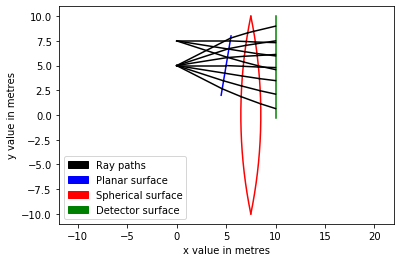

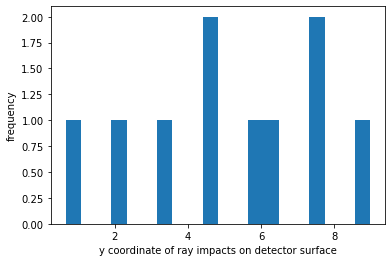

---------------------------


In [27]:
plot_trace_2d(numpy.array([[0.0, 7.5, numpy.pi/2.0],[0.0, 7.5, 1.1*numpy.pi/2.0],[0.0, 7.5, 1.2*numpy.pi/2.0],[0.0, 5.0, 0.7*numpy.pi/2.0],[0.0, 5.0, 0.8*numpy.pi/2.0],[0.0, 5.0, 0.9*numpy.pi/2.0], [0.0,5.0,numpy.pi/2.0],[0.0,5.0,1.1*numpy.pi/2.0], [0.0, 5.0, 1.2*numpy.pi/2.0], [0.0, 5.0, 1.3*numpy.pi/2.0]]),rrp,
                        [["PLA", numpy.array([4.5, 2.0, 5.5, 8.0,1.0,1.33])],
                        ["SPH", numpy.array([7.5, 10.0, 7.5, -10.0,1.33,1.5, 50.0])],
                        ["SPH", numpy.array([7.5, 10.0, 7.5, -10.0,1.33,1.5, -50.0])],
                        ["DET", 10.0]])
print("---------------------------")

## evaluate_trace_2d

In [33]:
frac = evaluate_trace_2d(rrp, 2.5) # 0.1 is not guaranteed to be a sensible value - adjust as required to test
print(frac)
print("returned data type is ",type(frac), " -- this should be", type(0.1))
print("---------------------------")

evaluate_trace_2d (TASK 5) (this test depends on the TASK 3 test functioning correctly)
0.7
returned data type is  <class 'float'>  -- this should be <class 'float'>
---------------------------


## optimize_surf_rad_2d

In [34]:
rad_opt = optimize_surf_rad_2d(numpy.array([[0.0,5.0,numpy.pi/2.0],[0.0,5.0,1.1*numpy.pi/2.0]]),
                                [["PLA", numpy.array([4.5, -8.0, 5.5, 8.0,1.0,1.33])],
                                ["SPH", numpy.array([0.0, -10.0,0.0,10.0,1.0,1.33,15.0])],
                                ["DET", 15.0]], 0.1, numpy.array([1]))
print(rad_opt)
print("returned data type is ",type(rad_opt), " -- this should be", type(numpy.array([1.0])))
print("returned data shape is ",rad_opt.shape, " -- this should be", numpy.array([1.0]).shape)
print("---------------------------")

[0.]
returned data type is  <class 'numpy.ndarray'>  -- this should be <class 'numpy.ndarray'>
returned data shape is  (1,)  -- this should be (1,)
---------------------------
